Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Archivo CSV de datos balanceados generado.

*** Modelo: Random Forest (con SMOTE) ***


c:\Users\Nicolle Saray\Desktop\Scikit learn\ikit_learn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nicolle Saray\Desktop\Scikit learn\ikit_learn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nicolle Saray\Desktop\Scikit learn\ikit_learn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Mejor umbral F1: 0.70
              precision    recall  f1-score   support

           0      0.941     0.933     0.937       119
           1      0.333     0.364     0.348        11

    accuracy                          0.885       130
   macro avg      0.637     0.648     0.642       130
weighted avg      0.889     0.885     0.887       130

Matriz de confusión:
 [[111   8]
 [  7   4]]
ROC-AUC: 0.71

*** Modelo: XGBoost (con SMOTE) ***


c:\Users\Nicolle Saray\Desktop\Scikit learn\ikit_learn\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:29:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor umbral F1: 0.62
              precision    recall  f1-score   support

           0      0.932     0.916     0.924       119
           1      0.231     0.273     0.250        11

    accuracy                          0.862       130
   macro avg      0.581     0.594     0.587       130
weighted avg      0.872     0.862     0.867       130

Matriz de confusión:
 [[109  10]
 [  8   3]]
ROC-AUC: 0.69


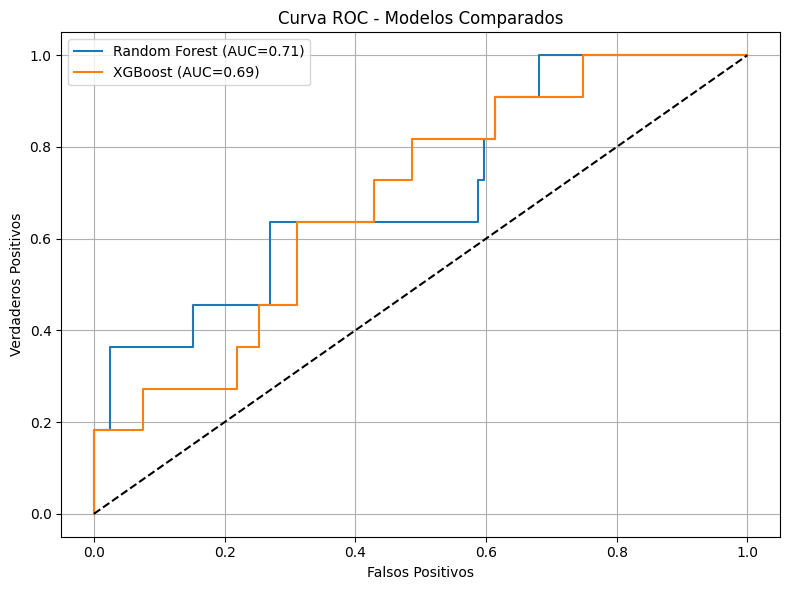

In [14]:
# Instalar librerías necesarias
%pip install xgboost
!pip install imbalanced-learn

# Importar librerías
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

# 1. Preparar datos
vars_objetivo = [
    'TIPO_VINCULACION', 'EDAD', 'TIEMPO_VINCULACION', 'UBICACION',
    'CAUSA_ACCIDENTE', 'SEXO', 'GRADO_ESCOLARIDAD', 'SECCION_EMPRESA'
]

# Asegurar que las columnas son string si se usa .str
for col in ['TIPO_VINCULACION', 'TIPO_LESION']:
    df[col] = df[col].astype(str)

df = df.dropna(subset=vars_objetivo + ['TIPO_LESION'])
df['TIPO_VINCULACION'] = df['TIPO_VINCULACION'].str.lower()
df['GRAVE'] = (df['TIPO_LESION'].str.lower() == 'muerte').astype(int)

# Codificación de variables categóricas
for col in ['TIPO_VINCULACION', 'UBICACION', 'CAUSA_ACCIDENTE', 'SEXO', 'GRADO_ESCOLARIDAD', 'SECCION_EMPRESA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Variables independientes y objetivo
X = df[vars_objetivo]
y = df['GRAVE']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Escalamiento de variables numéricas
scaler = StandardScaler()
X_train[['EDAD', 'TIEMPO_VINCULACION']] = scaler.fit_transform(X_train[['EDAD', 'TIEMPO_VINCULACION']])
X_test[['EDAD', 'TIEMPO_VINCULACION']] = scaler.transform(X_test[['EDAD', 'TIEMPO_VINCULACION']])

# Balanceo de datos
smote = SMOTE(random_state=42)
X_train_ros, y_train_ros = smote.fit_resample(X_train, y_train)

# Exportar datos balanceados para Tableau (opcional)
df_balanceado = pd.DataFrame(X_train_ros, columns=X_train.columns)
df_balanceado["GRAVE"] = y_train_ros.values
df_balanceado.to_csv("datos_balanceados_para_tableau.csv", index=False)
print("✅ Archivo CSV de datos balanceados generado.")

# Modelos a comparar
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(
        objective='binary:logistic', use_label_encoder=False,
        eval_metric='logloss', learning_rate=0.1, max_depth=5, n_estimators=200,
        subsample=0.8, random_state=42)
}

# Crear carpeta de resultados
Path("resultados").mkdir(parents=True, exist_ok=True)

metricas_lista = []
plt.figure(figsize=(8,6))

for nombre, modelo in modelos.items():
    print(f"\n*** Modelo: {nombre} (con SMOTE) ***")
    modelo.fit(X_train_ros, y_train_ros)
    y_prob = modelo.predict_proba(X_test)[:,1]

    # Buscar mejor umbral
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.3, 0.8, 0.02):
        y_pred_thresh = (y_prob >= thresh).astype(int)
        f1 = classification_report(y_test, y_pred_thresh, output_dict=True)['1']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    # Predicciones finales con mejor umbral
    y_pred_opt = (y_prob >= best_thresh).astype(int)
    print(f"Mejor umbral F1: {best_thresh:.2f}")
    print(classification_report(y_test, y_pred_opt, digits=3))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_opt))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.2f}")

    # Guardar resultados CSV
    result_df = X_test.copy()
    result_df['Real'] = y_test
    result_df['Probabilidad'] = y_prob
    result_df['Prediccion'] = y_pred_opt
    result_df.to_csv(f'resultados/resultados_{nombre.replace(" ", "_")}.csv', index=False)

    # Guardar métricas
    metricas_lista.append({
        'Modelo': nombre,
        'Umbral': best_thresh,
        'F1': best_f1,
        'AUC': roc_auc_score(y_test, y_prob)
    })

    # Gráfica ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC={roc_auc_score(y_test, y_prob):.2f})')

# Guardar métricas generales
pd.DataFrame(metricas_lista).to_csv("resultados/metricas_modelos.csv", index=False)

# Finalizar gráfica ROC
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC - Modelos Comparados')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("resultados/curva_ROC_comparada.png")
plt.show()


In [10]:
%pip uninstall imbalanced-learn -y
%pip install -U imbalanced-learn

Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Note: you may need to restart the kernel to use updated packages.
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
print("Resumen estadístico antes del balanceo:")
print(X_train.describe())
print("\nDistribución de la variable objetivo antes del balanceo:")
print(y_train.value_counts())

Resumen estadístico antes del balanceo:
       TIPO_VINCULACION          EDAD  TIEMPO_VINCULACION   UBICACION  \
count        390.000000  3.900000e+02        3.900000e+02  390.000000   
mean           2.012821 -9.109522e-18       -2.732857e-17    1.484615   
std            1.037765  1.001285e+00        1.001285e+00    0.567789   
min            1.000000 -3.017128e+00       -5.852072e-01    0.000000   
25%            1.000000 -6.664546e-01       -5.314755e-01    1.000000   
50%            1.500000 -7.878630e-02       -4.025194e-01    2.000000   
75%            3.000000  6.767872e-01       -6.938280e-02    2.000000   
max            4.000000  5.210228e+00        7.399325e+00    2.000000   

       CAUSA_ACCIDENTE        SEXO  GRADO_ESCOLARIDAD  SECCION_EMPRESA  
count       390.000000  390.000000         390.000000       390.000000  
mean          6.148718    0.989744           4.007692         3.405128  
std           3.791946    0.100883           2.646712         3.299914  
min       

In [16]:
print("\nMatriz de correlación antes del balanceo:")
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
print(corr_matrix)


Matriz de correlación antes del balanceo:
                    TIPO_VINCULACION      EDAD  TIEMPO_VINCULACION  UBICACION  \
TIPO_VINCULACION            1.000000  0.057803            0.397003   0.098498   
EDAD                        0.057803  1.000000            0.378353   0.008971   
TIEMPO_VINCULACION          0.397003  0.378353            1.000000   0.024624   
UBICACION                   0.098498  0.008971            0.024624   1.000000   
CAUSA_ACCIDENTE             0.271272 -0.114446           -0.036805   0.135986   
SEXO                       -0.023295  0.119120            0.039608   0.042118   
GRADO_ESCOLARIDAD          -0.101117 -0.050802           -0.010042  -0.081176   
SECCION_EMPRESA             0.156871 -0.057105            0.007900   0.084284   
GRAVE                      -0.111872 -0.005515           -0.077371   0.074016   

                    CAUSA_ACCIDENTE      SEXO  GRADO_ESCOLARIDAD  \
TIPO_VINCULACION           0.271272 -0.023295          -0.101117   
EDAD      

In [17]:
print("\nResumen estadístico después del balanceo:")
print(pd.DataFrame(X_train_ros, columns=X_train.columns).describe())
print("\nDistribución de la variable objetivo después del balanceo:")
print(pd.Series(y_train_ros).value_counts())

# Matriz de correlación después del balanceo
print("\nMatriz de correlación después del balanceo:")
corr_matrix_ros = pd.concat(
    [pd.DataFrame(X_train_ros, columns=X_train.columns), pd.Series(y_train_ros, name='GRAVE')],
    axis=1
).corr()
print(corr_matrix_ros)


Resumen estadístico después del balanceo:
       TIPO_VINCULACION        EDAD  TIEMPO_VINCULACION   UBICACION  \
count        716.000000  716.000000          716.000000  716.000000   
mean           1.708101   -0.042531           -0.133800    1.502793   
std            0.951989    0.961052            0.801401    0.597190   
min            1.000000   -3.017128           -0.585207    0.000000   
25%            1.000000   -0.582502           -0.531476    1.000000   
50%            1.000000   -0.162739           -0.427824    2.000000   
75%            3.000000    0.568105           -0.176846    2.000000   
max            4.000000    5.210228            7.399325    2.000000   

       CAUSA_ACCIDENTE        SEXO  GRADO_ESCOLARIDAD  SECCION_EMPRESA  
count       716.000000  716.000000         716.000000       716.000000  
mean          6.012570    0.970670           3.949721         2.913408  
std           2.904274    0.168847           2.625904         3.038824  
min           0.000000   

C:\Users\Nicolle Saray\AppData\Local\Temp\ipykernel_3272\3291728028.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GRAVE', data=df, palette='Set2')


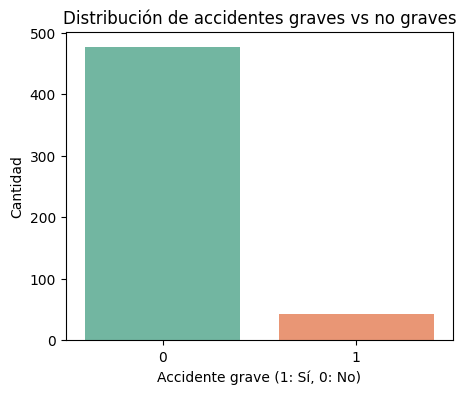

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x='GRAVE', data=df, palette='Set2')
plt.title("Distribución de accidentes graves vs no graves")
plt.xlabel("Accidente grave (1: Sí, 0: No)")
plt.ylabel("Cantidad")
plt.show()

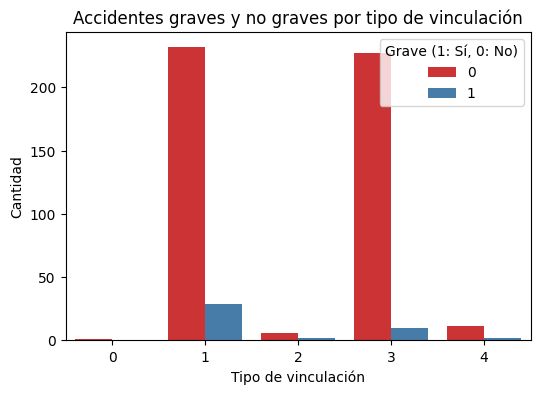

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x='TIPO_VINCULACION', hue='GRAVE', data=df, palette='Set1')
plt.title("Accidentes graves y no graves por tipo de vinculación")
plt.xlabel("Tipo de vinculación")
plt.ylabel("Cantidad")
plt.legend(title="Grave (1: Sí, 0: No)")
plt.show()

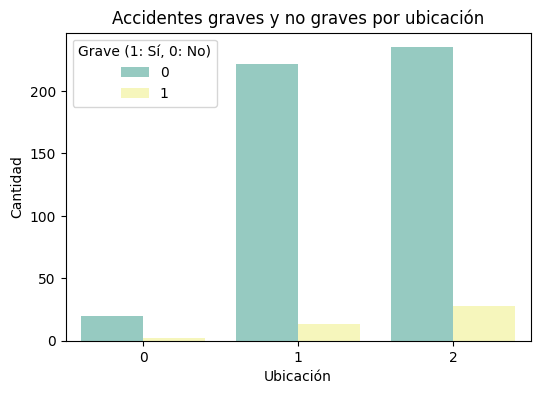

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x='UBICACION', hue='GRAVE', data=df, palette='Set3')
plt.title("Accidentes graves y no graves por ubicación")
plt.xlabel("Ubicación")
plt.ylabel("Cantidad")
plt.legend(title="Grave (1: Sí, 0: No)")
plt.show()